### 1. Load data

In [1]:
import os.path as op
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.naive_bayes import MultinomialNB, ComplementNB # naive Bayes
from sklearn.linear_model import SGDClassifier # SVM
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, cohen_kappa_score
%matplotlib inline

In [2]:
#train_fpath = '/home/veera/LST_project/data/train_data.csv'
#test_fpath = '/home/veera/LST_project/data/test_data.csv'
data_fpath = '/home/veera/LST_project/data/full_data.csv'
labels_col_name = 'Label'
id_col_name = 'id_str'

def download_from_csv(filename, labelled=False):
    # Helper for creating a matrix (ndarray) out of csv data
    df = pd.read_csv(filename, header=0)
    ids = df.pop(id_col_name)
    feature_names = np.asarray(df.columns.values)
    feature_names = feature_names[feature_names != 'Label']
    features = df.drop(labels_col_name, axis=1).values if labelled else df.values
    labels = df[labels_col_name].values if labelled else None       

    return features, labels, feature_names, ids

#X_train, y_train, feature_names = download_from_csv(train_fpath)
#X_test, y_test, _ = download_from_csv(test_fpath)
X, y, feature_names, ids = download_from_csv(data_fpath, labelled=True)
#print(X_train.shape, X_test.shape)
print(X.shape)
print(feature_names)

(1040, 500)
['across' 'act' 'action' 'actually' 'address' 'agenda' 'ago' 'agree'
 'agreenergoogle' 'air' 'air pollution' 'already' 'also' 'always'
 'america' 'american' 'amp' 'animal' 'announce' 'anyone' 'anything'
 'appreciate' 'apr' 'apr climate' 'april' 'area' 'around' 'article' 'ask'
 'atmosphere' 'attention' 'away' 'back' 'bad' 'bag' 'barackobama' 'base'
 'beautiful' 'become' 'begin' 'believe' 'bernie' 'best' 'biden' 'big'
 'billion' 'bin' 'biodiversity' 'bit' 'blue' 'box' 'building' 'business'
 'call' 'cant' 'car' 'carbon' 'carbon footprint' 'care' 'case' 'cause'
 'challenge' 'change' 'change denial' 'check' 'child' 'china' 'city'
 'claim' 'clean' 'clear' 'climate' 'climate action' 'climate change'
 'climate crisis' 'climate hi' 'climatechange' 'climatecrisis' 'close'
 'co' 'coal' 'come' 'community' 'company' 'consequence' 'consider'
 'content' 'continue' 'control' 'cop' 'corona' 'coronavirus' 'could'
 'country' 'course' 'covid' 'create' 'crisis' 'current' 'cut' 'date' 'day'
 'de

### 2. Explorative data analysis

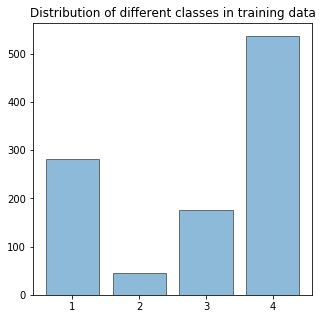

In [3]:
# visualize class distribution
fig1, ax = plt.subplots(1, 1, figsize=(5, 5))
hist = ax.hist(y, bins=np.arange(0.5, 5.5, 1), alpha=0.5, ec='black', rwidth=0.8)
ax.xaxis.set_ticks([i for i in range(1, 5)])
ax.set_title('Distribution of different classes in training data')

plt.show()

### 3. Define classifiers

In [4]:
# Unbalanced class weights
classifier_nb = ComplementNB()
classifier_sgd = SGDClassifier()

# Balanced class weights
classifier_sgd_balanced = SGDClassifier(class_weight='balanced')

### 4. Fit model and validate

In [5]:
# Confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
classifiers = [(classifier_nb, 'Naive Bayes'), (classifier_sgd, 'SVM'), (classifier_sgd_balanced, 'SVM with balanced classes')]
'''
for clf, title in classifiers:
    print(title)
    # Prediction accuracy score for testing data
    print("Score: %0.3f" % clf.score(X_test, y_test))
    X = np.vstack((X_train, X_test))
    y = np.hstack((y_train, y_test))
    cv_scores = cross_val_score(clf, X, y)
    print("Cross-validation accuracy: %0.3f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))
    y_pred = clf.predict(X_test)
    print("Precision: %0.3f" % precision_score(y_test, y_pred, average='macro'))
    print("Recall: %0.3f" % recall_score(y_test, y_pred, average='macro'))
    print("F1 score: %0.3f" % f1_score(y_test, y_pred, average='macro'))
    print('-' * 50)
'''
def cv(n_splits, X, y, clf, average_method):
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=777)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    kappa = []
    for train, test in kfold.split(X, y):
        fit = clf.fit(X[train], y[train])
        prediction = fit.predict(X[test])
        scores = fit.score(X[test],y[test])
        
        accuracy.append(scores)
        precision.append(precision_score(y[test], prediction, average=average_method))
        print('              positive   negative    neutral  unrelated')
        print('precision:', precision_score(y[test], prediction, average=None))
        recall.append(recall_score(y[test], prediction, average=average_method))
        print('recall:   ', recall_score(y[test], prediction, average=None))
        f1.append(f1_score(y[test], prediction, average=average_method))
        print('f1 score: ', f1_score(y[test], prediction, average=None))
        kappa.append(cohen_kappa_score(y[test], prediction))
        print('-' * 60)
    cnf_matrix = confusion_matrix(y[test], prediction)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[str(i+1) for i in range(4)], normalize=True,
                      title='Normalized confusion matrix')
    print("accuracy: %.3f (+/- %.2f)" % (np.mean(accuracy), np.std(accuracy)))
    print("precision: %.3f (+/- %.2f)" % (np.mean(precision), np.std(precision)))
    print("recall: %.3f (+/- %.2f)" % (np.mean(recall), np.std(recall)))
    print("f1 score: %.3f (+/- %.2f)" % (np.mean(f1), np.std(f1)))
    print('Cohen\'s kappa: %.3f (+/- %.2f)' % (np.mean(kappa), np.std(kappa)))
    plt.show()

Naive Bayes
              positive   negative    neutral  unrelated
precision: [0.50847458 0.33333333 0.35       0.828125  ]
recall:    [0.75       0.28571429 0.28       0.68831169]
f1 score:  [0.60606061 0.30769231 0.31111111 0.75177305]
------------------------------------------------------------
              positive   negative    neutral  unrelated
precision: [0.46153846 0.2        0.30434783 0.74025974]
recall:    [0.45       0.28571429 0.28       0.74025974]
f1 score:  [0.4556962  0.23529412 0.29166667 0.74025974]
------------------------------------------------------------
              positive   negative    neutral  unrelated
precision: [0.48148148 0.2        0.4375     0.87837838]
recall:    [0.65       0.14285714 0.28       0.84415584]
f1 score:  [0.55319149 0.16666667 0.34146341 0.86092715]
------------------------------------------------------------
              positive   negative    neutral  unrelated
precision: [0.45652174 0.22222222 0.23809524 0.80821918]
recall:    

/home/veera/anaconda3/envs/aalto-sci-project/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy: 0.604 (+/- 0.04)
precision: 0.441 (+/- 0.04)
recall: 0.447 (+/- 0.03)
f1 score: 0.440 (+/- 0.03)
Cohen's kappa: 0.374 (+/- 0.07)


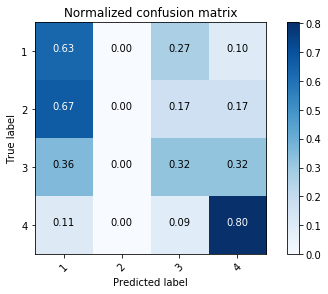



SVM
              positive   negative    neutral  unrelated
precision: [0.55555556 0.6        0.32258065 0.80519481]
recall:    [0.5        0.42857143 0.4        0.80519481]
f1 score:  [0.52631579 0.5        0.35714286 0.80519481]
------------------------------------------------------------
              positive   negative    neutral  unrelated
precision: [0.51351351 0.33333333 0.39285714 0.73076923]
recall:    [0.475      0.28571429 0.44       0.74025974]
f1 score:  [0.49350649 0.30769231 0.41509434 0.73548387]
------------------------------------------------------------
              positive   negative    neutral  unrelated
precision: [0.45454545 0.6        0.31578947 0.77777778]
recall:    [0.5        0.42857143 0.24       0.81818182]
f1 score:  [0.47619048 0.5        0.27272727 0.79746835]
------------------------------------------------------------
              positive   negative    neutral  unrelated
precision: [0.48       0.33333333 0.27272727 0.74324324]
recall:    [0.6  

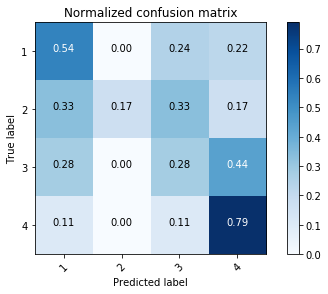



SVM with balanced classes
              positive   negative    neutral  unrelated
precision: [0.5        0.66666667 0.26315789 0.81690141]
recall:    [0.425      0.57142857 0.4        0.75324675]
f1 score:  [0.45945946 0.61538462 0.31746032 0.78378378]
------------------------------------------------------------
              positive   negative    neutral  unrelated
precision: [0.58064516 0.         0.32432432 0.75324675]
recall:    [0.45       0.         0.48       0.75324675]
f1 score:  [0.50704225 0.         0.38709677 0.75324675]
------------------------------------------------------------
              positive   negative    neutral  unrelated
precision: [0.48076923 0.66666667 0.38095238 0.83561644]
recall:    [0.625      0.28571429 0.32       0.79220779]
f1 score:  [0.54347826 0.4        0.34782609 0.81333333]
------------------------------------------------------------
              positive   negative    neutral  unrelated
precision: [0.475      0.28571429 0.26086957 0.73417

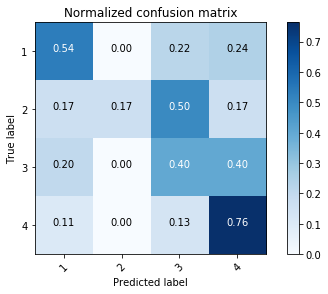

In [7]:
for clf, title in classifiers:
    print(title)
    cv(7, X, y, clf, 'macro')
    print('\n')

In [8]:
print("Top 10 keywords per class:")
for clf, title in classifiers:
    print(title)
    for i in range(4):
        top10 = np.argsort(clf.coef_[i])[-10:]
        print("%s: %s" % (i+1, ", ".join(feature_names[top10])))
    print('-' * 60)

Top 10 keywords per class:
Naive Bayes
1: humanity, vehicle emission, change denial, billion, climate crisis, fight climate, rollback, require, stop funding, gop
2: watch, grow, fight climate, hard, consider, large, ice, hoax, gop, begin
3: information, ocean, gop, watch, greenhouse, hard, globalwarming, base, large, glasgow
4: lo, lo precip, instead, apr climate, precip, precip snow, bag, date, hour, seem
------------------------------------------------------------
SVM
1: though, climatecrisis, require, lie, important, production, billion, tell, forward, earth
2: climate change, barackobama, probably, control, green, effect, climate, realdonaldtrump, people, greta
3: vehicle, side, car, single, fall, gas, big, may, healthcare, scientist
4: didnt, date, dioxide, ensure, huge, open, food, turn, fear, india
------------------------------------------------------------
SVM with balanced classes
1: step, climate action, production, lie, climatecrisis, require, important, tell, forward, eart

### 5. Apply the model

In [14]:
cities = ['chicago', 'houston', 'miami', 'philadelphia', 'phoenix']
data_files = ['/home/veera/LST_project/data/%s/full_data.csv' % city for city in cities]

classifier = classifier_sgd_balanced
fit = classifier.fit(X, y)
for f in data_files:
    try:
        X_new, _, _, ids = download_from_csv(f)
        y_new_pred = fit.predict(X_new)
        outfile = op.join(op.dirname(f), 'predictions.csv')
        df = pd.DataFrame(np.c_[ids, y_new_pred], columns=[id_col_name, 'Label'])
        df.to_csv(outfile, index=False)
    except FileNotFoundError:
        print('file', f, 'not found')

file /home/veera/LST_project/data/houston/full_data.csv not found
file /home/veera/LST_project/data/miami/full_data.csv not found
file /home/veera/LST_project/data/philadelphia/full_data.csv not found
file /home/veera/LST_project/data/phoenix/full_data.csv not found
